In [177]:
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt

In [221]:
# Chargement des données
df = pd.read_csv("ecommerce_nettoye.csv", encoding="ISO-8859-1")

In [222]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

|Variables| Descriptions
|:--|:--|
|**InvoiceNo** | *Numéro de la facture.*|
|**StockCode** | *Code de l'article .*|
|**Description** | *Description ou nom de l'article.*|
|**Quantity** | *Quantité de chaque article.*|
|**InvoiceDate** | *Date et heure de la facture.*|
|**UnitPrice** | *Prix unitaire de larticleNuméro d'identification d'indenti*|
|**CustomerID** | *Bumero d'identifcation*|
|**Country** |*Pays où le client reside*|

In [202]:
print('Orders from {} to {}'.format(df['InvoiceDate'].min(),
                                    df['InvoiceDate'].max()))


Orders from 2010-12-01 08:26:00 to 2011-12-09 12:50:00


Nous disposons d'environ un an de données de ventes (de décembre 2010 à décembre 2011). C'est la période généralement utilisée pour l'analyse RFM.

In [223]:
# Conversion de la date
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [224]:
df['Mont_total'] = df['Quantity'] * df['UnitPrice']

In [225]:
df['InvoiceNo'].value_counts().head()

# Date de référence pour le calcul de la récence
date_ref = df['InvoiceDate'].max() + timedelta(days=1)

# Calcul des composantes RFM
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (date_ref - x.max()).days,
    'InvoiceNo': 'nunique',
    'Mont_total': 'sum'
}).reset_index()

rfm.columns = ['CustomerID', 'Recence', 'Frequence', 'Montant']


In [226]:
# Agrégation des commandes par client :
orders = df.groupby(['InvoiceNo', 'InvoiceDate', 'CustomerID']).agg({'Mont_total': lambda x: x.sum()}).reset_index()
orders.head()

,InvoiceNo,InvoiceDate,CustomerID,Mont_total
0,536365,2010-12-01 08:26:00,17850.0,139.12
1,536366,2010-12-01 08:28:00,17850.0,22.20
2,536367,2010-12-01 08:34:00,13047.0,278.73
3,536368,2010-12-01 08:34:00,13047.0,70.05
4,536369,2010-12-01 08:35:00,13047.0,17.85


In [227]:
# Date de référence pour le calcul de la récence
data_analys = orders['InvoiceDate'].max() + timedelta(days=1)
data_analys

Timestamp('2011-12-10 12:50:00')

In [228]:
period=orders['InvoiceDate'].max()-orders['InvoiceDate'].min()
period

Timedelta('373 days 04:24:00')

In [229]:
# Calcul des données RFM

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (data_analys - x.max()).days,   
    'InvoiceNo': 'nunique',                                     
    'Mont_total': 'sum'                                         
}).reset_index()

rfm.columns = ['CustomerID', 'Recence', 'Frequence', 'Montant']


In [230]:
## Calcul de la recence
orders['recences_calcul']=orders['InvoiceDate'].apply(lambda x: (data_analys-x).days)
orders.head(5)

,InvoiceNo,InvoiceDate,CustomerID,Mont_total,recences_calcul
0,536365,2010-12-01 08:26:00,17850.0,139.12,374
1,536366,2010-12-01 08:28:00,17850.0,22.20,374
2,536367,2010-12-01 08:34:00,13047.0,278.73,374
3,536368,2010-12-01 08:34:00,13047.0,70.05,374
4,536369,2010-12-01 08:35:00,13047.0,17.85,374


In [231]:
# Calcul des quartiles
quantiles = rfm[['Recence', 'Frequence', 'Montant']].quantile([0.25, 0.5, 0.75])
quantiles = quantiles.to_dict()

# Fonctions de scoring
def r_score(x):
    if x <= quantiles['Recence'][0.25]:
        return 4
    elif x <= quantiles['Recence'][0.5]:
        return 3
    elif x <= quantiles['Recence'][0.75]:
        return 2
    else:
        return 1

def fm_score(x, var):
    if x <= quantiles[var][0.25]:
        return 1
    elif x <= quantiles[var][0.5]:
        return 2
    elif x <= quantiles[var][0.75]:
        return 3
    else:
        return 4

# Application des scores
rfm['R'] = rfm['Recence'].apply(r_score)
rfm['F'] = rfm['Frequence'].apply(lambda x: fm_score(x, 'Frequence'))
rfm['M'] = rfm['Montant'].apply(lambda x: fm_score(x, 'Montant'))
rfm['RFM_Score'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)
rfm.head(10)



,CustomerID,Recence,Frequence,Montant,R,F,M,RFM_Score
0,12346.0,326,2,0.00,1,2,1,121
1,12347.0,2,7,4310.00,4,4,4,444
2,12348.0,75,4,1797.24,2,3,4,234
3,12349.0,19,1,1757.55,3,1,4,314
4,12350.0,310,1,334.40,1,1,2,112
5,12352.0,36,11,1545.41,3,4,3,343
6,12353.0,204,1,89.00,1,1,1,111
7,12354.0,232,1,1079.40,1,1,3,113
8,12355.0,214,1,459.40,1,1,2,112
9,12356.0,23,3,2811.43,3,2,4,324


In [232]:
#  Proposition de contrat de maintenance par segment
contrat = {
    r'[1-2][1-2]': 'en hibernation',
    r'[1-2][3-4]': 'à risque',
    r'[1-2]5': 'à ne pas perdre',
    r'3[1-2]': 'sur le point de dormir',
    r'33': 'nécessite de l\'attention',
    r'[3-4][4-5]': 'clients fidèles',
    r'41': 'prometteurs',
    r'51': 'nouveaux clients',
    r'[4-5][2-3]': 'clients potentiellement fidèles',
    r'5[4-5]': 'champions'
}



In [233]:
rfm['Segment'] = rfm['R'].map(str) + rfm['F'].map(str)
rfm['Segment'] = rfm['Segment'].replace(contrat, regex=True)
rfm.head(10)


,CustomerID,Recence,Frequence,Montant,R,F,M,RFM_Score,Segment
0,12346.0,326,2,0.00,1,2,1,121,en hibernation
1,12347.0,2,7,4310.00,4,4,4,444,clients fidèles
2,12348.0,75,4,1797.24,2,3,4,234,à risque
3,12349.0,19,1,1757.55,3,1,4,314,sur le point de dormir
4,12350.0,310,1,334.40,1,1,2,112,en hibernation
5,12352.0,36,11,1545.41,3,4,3,343,clients fidèles
6,12353.0,204,1,89.00,1,1,1,111,en hibernation
7,12354.0,232,1,1079.40,1,1,3,113,en hibernation
8,12355.0,214,1,459.40,1,1,2,112,en hibernation
9,12356.0,23,3,2811.43,3,2,4,324,sur le point de dormir


| Segment                               | Description                                                                                     |
| ----------------------------------- | ----------------------------------------------------------------------------------------------- |
| **Champions**                       | Clients les plus récents, fidèles et avec des achats fréquents. Ce sont vos meilleurs clients ! |
| **Clients potentiellement fidèles** | Clients ayant un bon historique récent et une fréquence moyenne. Ils peuvent devenir champions. |
| **Nouveaux clients**                | Clients récents mais encore peu fidèles. À accueillir et engager rapidement.                    |
| **Prometteurs**                     | Clients récents avec peu d’achats. Montrez-leur plus de valeur pour les fidéliser.              |
| **Clients fidèles**                 | Achètent souvent, mais pas nécessairement récemment. Très engagés.                              |
| **Nécessite de l'attention**        | Clients modérés en fréquence et récence. À surveiller pour éviter qu’ils ne partent.            |
| **Sur le point de dormir**          | Clients achetaient régulièrement mais ont ralenti. Une relance pourrait aider.                  |
| **À ne pas perdre**                 | Clients très fidèles auparavant mais récents achats faibles. À relancer rapidement.             |
| **À risque**                        | Clients qui étaient bons mais qui n’ont pas acheté depuis longtemps. À réactiver.               |
| **En hibernation**                  | Clients anciens avec très peu d’activité. Peu d'engagement actuel.                              |


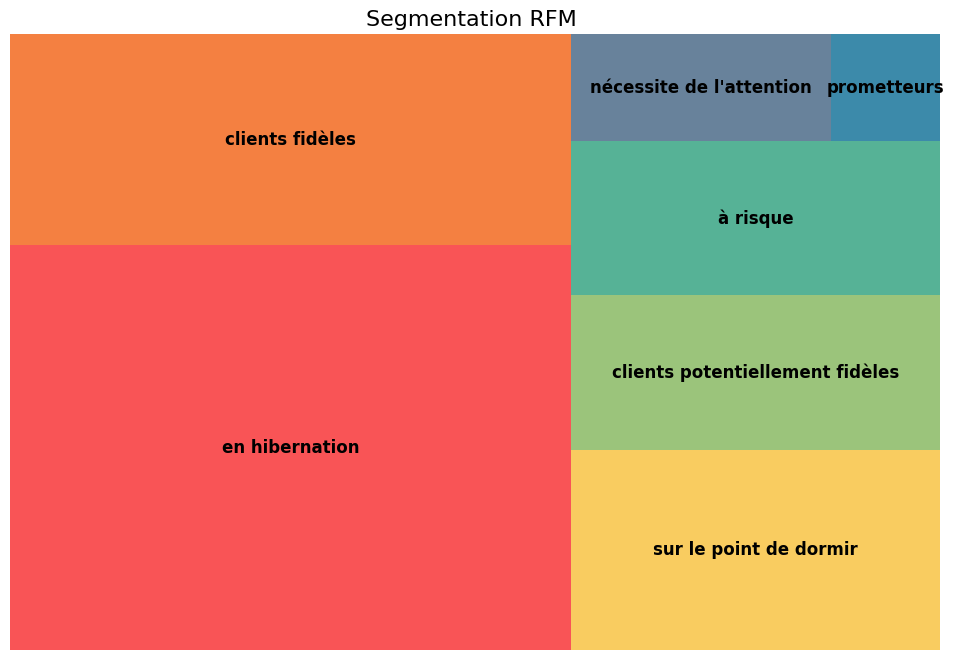

In [234]:
import matplotlib.pyplot as plt
import squarify
import pandas as pd

# Compter le nombre de clients par segment
segment_counts = rfm['Segment'].value_counts().reset_index()
segment_counts.columns = ['Segment', 'Nombre']

# Couleurs personnalisées 
colors = ['#f94144', '#f3722c', '#f9c74f', '#90be6d', '#43aa8b',
          '#577590', '#277da1', '#4d908e', '#f9844a', '#8ac926']

plt.figure(figsize=(12, 8))
squarify.plot(sizes=segment_counts['Nombre'],
              label=segment_counts['Segment'],
              color=colors,
              alpha=.9,
              text_kwargs={'fontsize': 12, 'weight': 'bold'})

plt.title("Segmentation RFM ", fontsize=16)
plt.axis('off')  
plt.show()


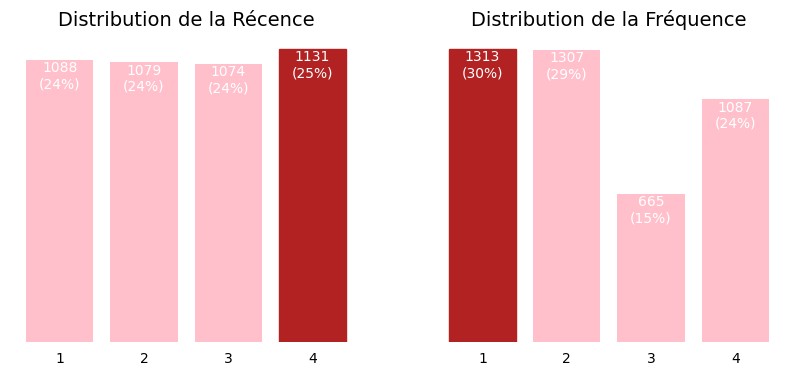

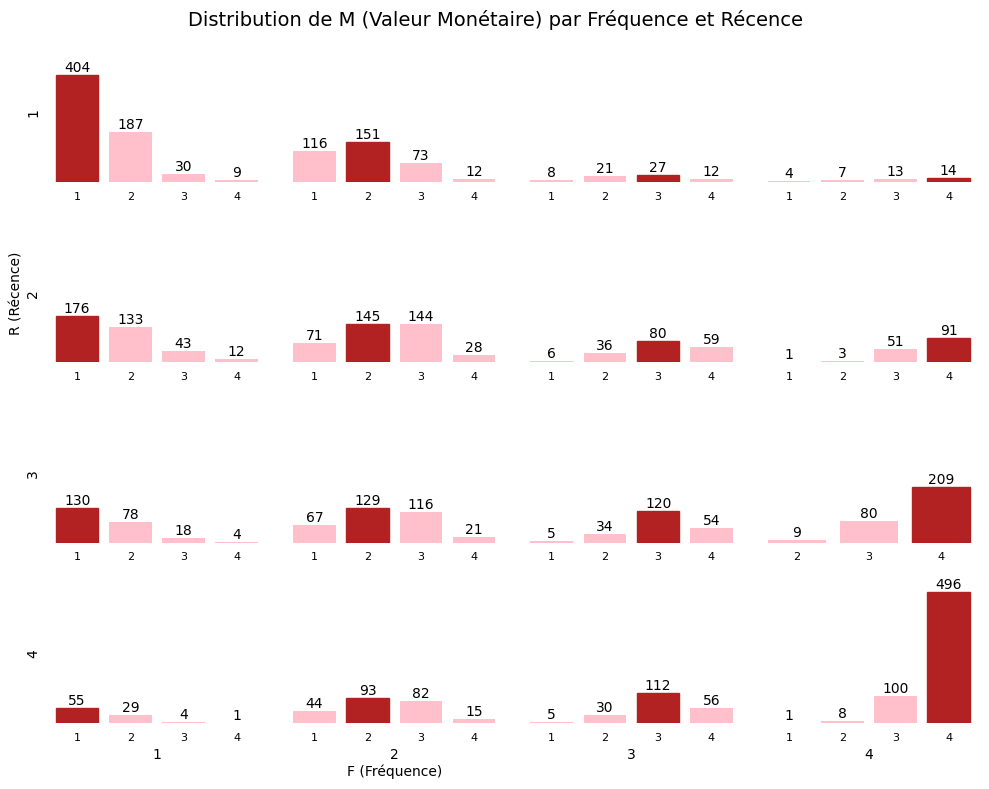

In [235]:
# Tracer la distribution des clients par R et F
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

for i, p in enumerate(['R', 'F']):
    parameters = {'R':'Récence', 'F':'Fréquence'}
    y = rfm[p].value_counts().sort_index()
    x = y.index
    ax = axes[i]
    bars = ax.bar(x, y, color='pink')
    ax.set_frame_on(False)
    ax.tick_params(left=False, labelleft=False, bottom=False)
    ax.set_title('Distribution de la {}'.format(parameters[p]),
                fontsize=14)
    for bar in bars:
        value = bar.get_height()
        if value == y.max():
            bar.set_color('firebrick')
        ax.text(bar.get_x() + bar.get_width() / 2,
                value - 5,
                '{}\n({}%)'.format(int(value), int(value * 100 / y.sum())),
               ha='center',
               va='top',
               color='w')

plt.show()

# Tracer la distribution de M par score RF
fig, axes = plt.subplots(nrows=4, ncols=4,
                         sharex=False, sharey=True,
                         figsize=(10, 8))

r_range = range(1, 5)
f_range = range(1, 5)

for r in r_range:
    for f in f_range:
        y = rfm[(rfm['R'] == r) & (rfm['F'] == f)]['M'].value_counts().sort_index()
        x = y.index
        ax = axes[r - 1, f - 1]
        bars = ax.bar(x, y, color='pink')
        
        if r == 4:
            if f == 2:
                ax.set_xlabel('{}\nF (Fréquence)'.format(f), va='top')
            else:
                ax.set_xlabel('{}\n'.format(f), va='top')
                
        if f == 1:
            if r == 2:
                ax.set_ylabel('R (Récence)\n{}'.format(r))
            else:
                ax.set_ylabel(str(r))
                
        ax.set_frame_on(False)
        ax.tick_params(left=False, labelleft=False, bottom=False)
        ax.set_xticks(x)
        ax.set_xticklabels(x, fontsize=8)

        for bar in bars:
            value = bar.get_height()
            if value == y.max():
                bar.set_color('firebrick')
            ax.text(bar.get_x() + bar.get_width() / 2,
                    value,
                    int(value),
                    ha='center',
                    va='bottom',
                    color='k')
                    
fig.suptitle('Distribution de M (Valeur Monétaire) par Fréquence et Récence',
             fontsize=14)
plt.tight_layout()
plt.show()

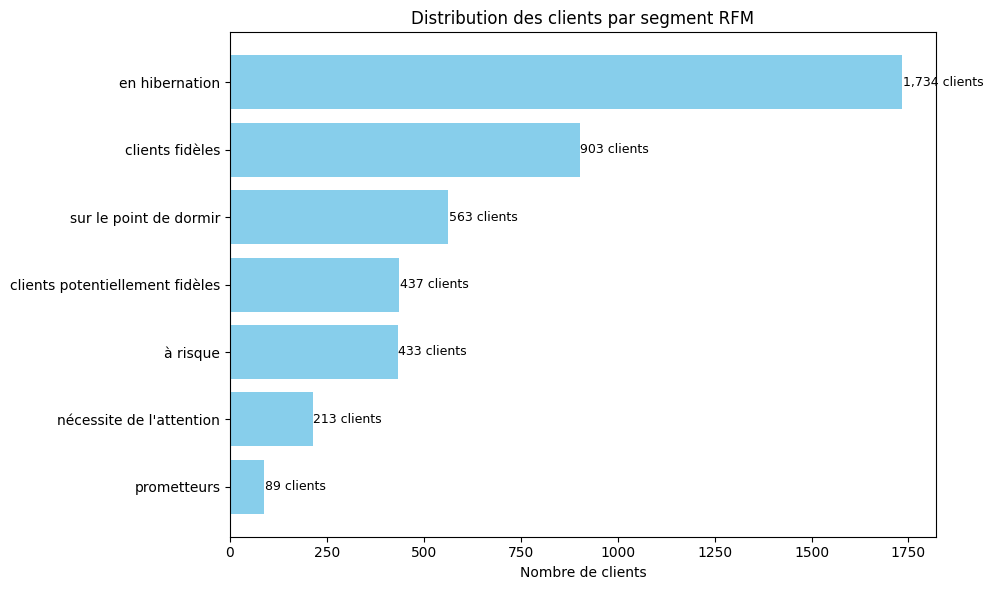

In [236]:
import matplotlib.pyplot as plt

# Compter le nombre de clients dans chaque segment
segments_counts = rfm['Segment'].value_counts().sort_values()

# Créer le graphique
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(range(len(segments_counts)), segments_counts.values, color='skyblue')

# Ajouter les noms de segments
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

# Ajouter les valeurs sur les barres
for i, bar in enumerate(bars):
    value = bar.get_width()
    ax.text(value + 1, bar.get_y() + bar.get_height()/2,
            f'{value:,} clients', va='center', fontsize=9)

ax.set_title("Distribution des clients par segment RFM")
ax.set_xlabel("Nombre de clients")
plt.tight_layout()
plt.show()


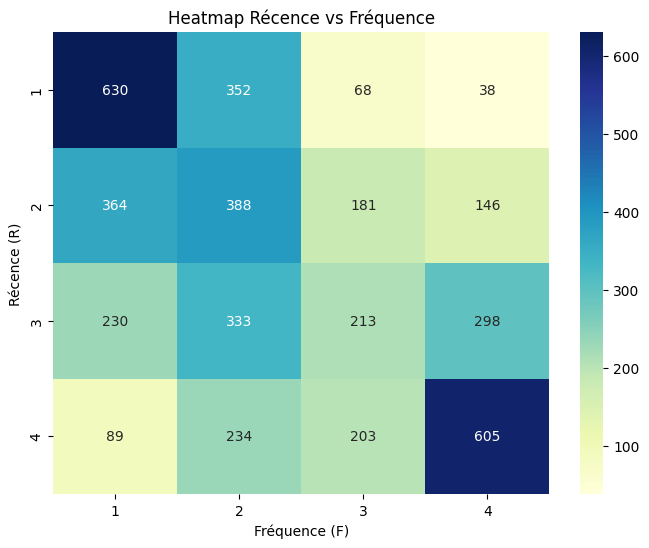

In [237]:
import seaborn as sns

# Créer une matrice de fréquence R-F
rf_matrix = rfm.groupby(['R', 'F']).size().unstack().fillna(0)

# Tracer la heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(rf_matrix, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Heatmap Récence vs Fréquence")
plt.xlabel("Fréquence (F)")
plt.ylabel("Récence (R)")
plt.show()


In [238]:
# Sauvegarde dans un fichier CSV
rfm.to_csv("RFM_segmenté.csv", index=False)

print(" Fichier exporté sous le nom : RFM_segmenté.csv")


 Fichier exporté sous le nom : RFM_segmenté.csv


In [239]:
# Affichage d’un échantillon des données RFM avec segmentation
print(rfm.head())


   CustomerID  Recence  Frequence  Montant  R  F  M RFM_Score  \
0     12346.0      326          2     0.00  1  2  1       121   
1     12347.0        2          7  4310.00  4  4  4       444   
2     12348.0       75          4  1797.24  2  3  4       234   
3     12349.0       19          1  1757.55  3  1  4       314   
4     12350.0      310          1   334.40  1  1  2       112   

                  Segment  
0          en hibernation  
1         clients fidèles  
2                à risque  
3  sur le point de dormir  
4          en hibernation  
